{'cells': [{'cell_type': 'code', 'execution_count': 11, 'metadata': {}, 'outputs': [], 'source': ['%load_ext line_profiler']}, {'cell_type': 'code', 'execution_count': None, 'metadata': {}, 'outputs': [], 'source': ['#@title: SIM Constants and setup parameters\n', '\n', 'import numpy as np\n', '\n', '# ---------------------\n', '# Constants\n', '# ---------------------\n', 'r0 = 2.8179403227e-15  # Classical electron radius in meters\n', 'm_e_c2 = 0.511         # Electron rest energy in MeV\n', '\n', 'phan_size: int = 128\n', 'phan_channels: int = 2 # Channel 0: Scattering Coefficient, Channel 1: Attenuation Coefficient\n', 'chan_scat: int = 0\n', 'chan_atten: int = 1\n', '\n', 'E0 = 1.0 # Effective "peak" energy of a 6MeV radiotherapy beam\n', 'voxel_physical_scale_len: float = 0.001 # 1 metre to 1mm thereabouts\n', 'voxel_physical_scale_atten: float = 0.01 # For our mass attenuation coefficients, which use cm^2. We will convert to mm^2\n', 'theta: float = 0 # np.pi * (-2/6) # Unused 

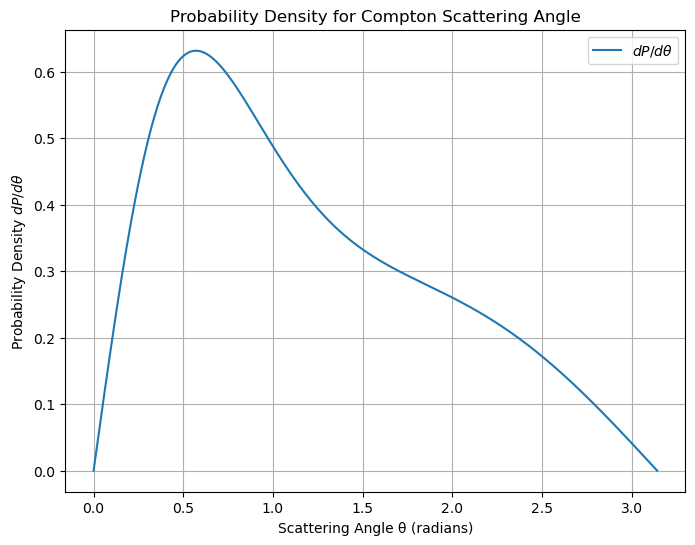

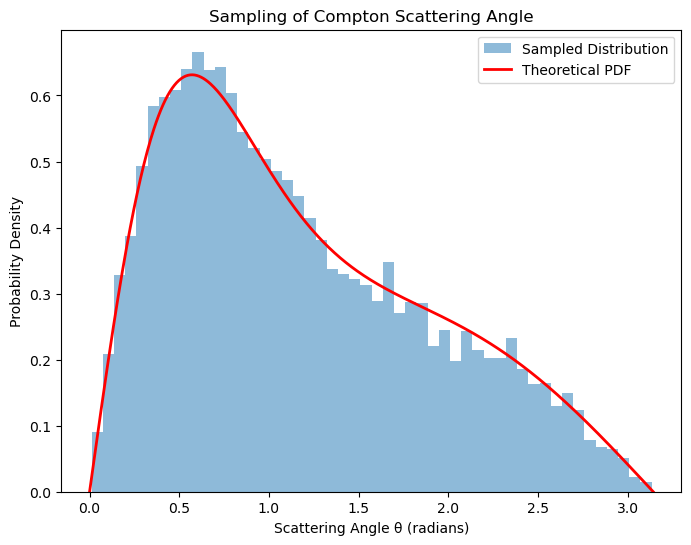

Detector energy range: 0.324 MeV to 0.353 MeV
Found a cell to run: #@title SIM 3D Phantom Definition

Found a cell to run: #@title SIM Siddon Jacobs 3D

Found a cell to run: #@title SIM Full Generalised Radon Transform for One detector point

Found a cell to run: #@title SIM Iterating Radon transform over detector point grid



In [1]:
# Load our Lircst-ana notebook (as json) into memory

from json import load
import sys

filename = '/home/samnub/dev/lircst-ana/src/AnalyticalCST.ipynb'

# Import the directory of lircst-ana to get context for local imports
sys.path.append('/home/samnub/dev/lircst-ana/src/')

nb = None

with open(filename, 'r') as f:
    nb = load(f)
    print(nb)

for cell in nb['cells']:
    if cell['cell_type'] == 'code':
        source = cell['source']
        # Our unique keyword to identify cells to run is "SIM in the first line"
        if not 'SIM' in source[0]:
            continue

        print(f'Found a cell to run: {source[0]}')
        # We can run the cell by executing the source code
        source = ''.join(line for line in cell['source'] if not line.startswith('%'))
        exec(source, globals(), locals())



In [ ]:
# Let's discretise our forward model which we've just imported into memory

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def auxiliary_phan_gen(x: int, y: int) -> np.ndarray:
    # Returns a 2D Phantom Auxiliary image where pixel x,y is 1 and all others are 0
    aux = np.zeros((phan_channels, phan_size, phan_size, phan_size), dtype=np.float64)
    aux[:, x, y, :] = 1.0
    return aux

# Opreator matrix A, for parameters u and theta
A_ut: np.ndarray = np.zeros((phan_size * len(theta_linspace), phan_size * phan_size), dtype=np.float64)

# Operator matrix A, for parameters u and bins
A_ub: np.ndarray = np.zeros((phan_size * len(bin_linspace), phan_size * phan_size), dtype=np.float64)

# Operator matrix A, for parameters theta and bins
A_tb: np.ndarray = np.zeros((len(theta_linspace) * len(bin_linspace), phan_size * phan_size), dtype=np.float64)

print(f'Operator matrix A_ut shape: {A_ut.shape}')
print(f'Operator matrix A_ub shape: {A_ub.shape}')
print(f'Operator matrix A_tb shape: {A_tb.shape}')

# Let's fill the operator matrix A_ut
for i in range(phan_size):
    for j in range(phan_size):
        aux = auxiliary_phan_gen(i, j)

        # Run our forward model on the auxiliary phantom
        y = radon_over_detector_pixels(aux, detec_size, detec_dims, detec_bins, sinogram_slice=phan_size//2) # Arbitrary slice number

        y_ut: np.ndarray = np.sum(y, axis=2)
        y_ub: np.ndarray = np.sum(y, axis=1)
        y_tb: np.ndarray = np.sum(y, axis=0)

        # Fill the operator matrix A_ut
        A_ut[:, i * phan_size + j] = y_ut.ravel()

        # Fill the operator matrix A_ub
        A_ub[:, i * phan_size + j] = y_ub.ravel()

        # Fill the operator matrix A_tb
        A_tb[:, i * phan_size + j] = y_tb.ravel()

        fig_ut = plt.figure(figsize=(8, 6))
        plt.imshow(y_ut)
        plt.title(f'y_ut for pixel ({i}, {j})')
        plt.colorbar()
        display(fig_ut)

        fig_ub = plt.figure(figsize=(8, 6))
        plt.imshow(y_ub)
        plt.title(f'y_ub for pixel ({i}, {j})')
        plt.colorbar()
        display(fig_ub)

        fig_tb = plt.figure(figsize=(8, 6))
        plt.imshow(y_tb)
        plt.title(f'y_tb for pixel ({i}, {j})')
        plt.colorbar()
        display(fig_tb)

        clear_output(wait=True)
        plt.close(fig_ut)
        plt.close(fig_ub)
        plt.close(fig_tb)
